# Example: Image segmentation using customized UNET 3+

In [1]:
import numpy as np
from glob import glob

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

This example requires keras-unet-collection:
```
pip install keras-unet-collection
```

In [3]:
from keras_unet_collection import models, base, utils

In [4]:
# indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = 'system/drive/oxford_iiit/'

## The Oxford-IIIT Pets dataset

The dataset that will be used for this example is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al. 2012). This dataset contains images of pets and their pixel-wise mask that indicates (1) pixels belonging to the pet, (2) pixels bordering the pet, and (3) surrounding pixels.

The Oxford-IIIT Pets dataset will be downloaded and unpacked through the cell blow.

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)

## Customizing a segmentation model based on UNET 3+

In this example, an image segmentation model is proposed to classify the pixel mask by taking the re-sized RGB images as inputs.

The architecture of UNET 3+ is applied in this segmentation task. UNET 3+ is a convolutional neural network with encoder-decoder blocks, similar to the conventionally used Unet, and with technical highlights of full-scale skip connections, deep supervision, and classification-guided module (CGM). In Huang et al. (2020), UNET 3+ overperformed Unet and Unet++ in the dataset of ISBI LiTS 2017 Challenge.

We specify five downsampling levels with the number of convolution filter grows from 32 to 512. Each downsampling level consists of two convolutional layers. Upsampling levels are also specified with each level accepts five 32-channel tensors produced by full-scale skip connections, and after layer fusion, tensors of 160 channels are obtained for upsampling. These tensors are processed through a convolutional layer with 160 filters, and the resulting feature maps are collected and fed into the output section. 

The code cell below configures the base architecture of this segmentation model. The input size is fixed to 128-by-128. Batch normalization is applied after each of the convolutional layers. Down- and upsampling are achieved through maxpooling and bilinear interpolation, respectively.

In [6]:
name = 'unet3plus'
activation = 'ReLU'
filter_num_down = [32, 64, 128, 256, 512]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 3

# `unet_3plus_2d_base` accepts an input tensor 
# and produces output tensors from different upsampling levels
# ---------------------------------------- #
input_tensor = keras.layers.Input((128, 128, 3))
# base architecture
X_decoder = base.unet_3plus_2d_base(
    input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate, 
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
    batch_norm=True, pool=True, unpool=True, name=name)

The collected feature maps as four-dimensional tensors of (sample number, width, height, channel) are shown as follows:

In [7]:
X_decoder

[<tf.Tensor 'unet3plus_down_4_1_activation/Relu:0' shape=(None, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'unet3plus_fusion_conv_0_0_activation/Relu:0' shape=(None, 16, 16, 160) dtype=float32>,
 <tf.Tensor 'unet3plus_fusion_conv_1_0_activation/Relu:0' shape=(None, 32, 32, 160) dtype=float32>,
 <tf.Tensor 'unet3plus_fusion_conv_2_0_activation/Relu:0' shape=(None, 64, 64, 160) dtype=float32>,
 <tf.Tensor 'unet3plus_fusion_conv_3_0_activation/Relu:0' shape=(None, 128, 128, 160) dtype=float32>]

**Deep supervision**

The output section of UNET 3+ consists of deep-supervision and Classification-guided Module (CGM).

Deep-supervision upsamples intermediate feature maps into full-resolution and enables the back-propagation of loss values from these full-resolution branches. Based on Huang et al. (2020). The deep-supervision of UNET 3+ are organized as 3-by-3 convolutional layers followed by bilinear-interpolation-based upsampling and sigmoid output activation.

The code cell below constructs the deep-supervisions. Alternatively, `keras_unet_collection.models.unet_3plus_2d` with `deep_supervision=True` produces a keras model that contatins deep-supervision branches.

In [8]:
# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices 
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])
    
    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear', 
                     name='{}_output_sup{}'.format(name, i-1))(X)
    
    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

The deep-supervision and final output tensors are shown as follows:

In [9]:
OUT_stack

[<tf.Tensor 'unet3plus_output_sup0_activation/Sigmoid:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup1_activation/Sigmoid:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup2_activation/Sigmoid:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup3_activation/Sigmoid:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_final_activation/Sigmoid:0' shape=(None, 128, 128, 3) dtype=float32>]

**Classification-guided Module (CGM)**

Huang et al. (2020) proposed CGM for handling the over-segmentation problem. CGM takes the output tensor of the deepest downsampling level, and converts it into a single value that indicates the probability of the existence of the segmentation target.

The code cell below adds CGM into the existing deep-supervision branches.

In [10]:
# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1)

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))

In [11]:
OUT_stack

[<tf.Tensor 'unet3plus_output_sup0_CGM/mul:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup1_CGM/mul:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup2_CGM/mul:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_sup3_CGM/mul:0' shape=(None, 128, 128, 3) dtype=float32>,
 <tf.Tensor 'unet3plus_output_final_CGM/mul:0' shape=(None, 128, 128, 3) dtype=float32>]

**Compiling the segmentation model**

The segmentation model is trained with cross-entropy loss. Each deep-supervision branch contributes 12.5% of the total loss value, whereas the final output loss contribution is 50%. The Adam optimizer with a learning rate of 1E-4 is applied.

In [12]:
unet3plus = keras.models.Model([input_tensor,], OUT_stack)

In [13]:
unet3plus.compile(loss=[keras.losses.categorical_crossentropy,
                        keras.losses.categorical_crossentropy,
                        keras.losses.categorical_crossentropy,
                        keras.losses.categorical_crossentropy,
                        keras.losses.categorical_crossentropy],
                 loss_weights=[0.25, 0.25, 0.25, 0.25, 1.0],
                 optimizer=keras.optimizers.Adam(lr=1e-4))

## Data preprocessing

The RGB images are resized to 128-by-128 through the nearest neighbour method, and normalized to the interval of [0, 1]. The pixel-wise mask is resized similarly, and obtained as the target.

A random split is applied with 80%, 10%, 10% of the samples are assigned for training, validation, and testing, respectively.

In [14]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting tri-mask of {1, 2, 3} to three categories.'''
    return keras.utils.to_categorical(target_array-1)

In [15]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.8*L); L_valid = int(0.1*L); L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]
print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 5912:739:739


In [16]:
valid_input = input_data_process(utils.image_to_array(sample_names[ind_valid], size=128, channel=3))
valid_target = target_data_process(utils.image_to_array(label_names[ind_valid], size=128, channel=1))

In [17]:
test_input = input_data_process(utils.image_to_array(sample_names[ind_test], size=128, channel=3))
test_target = target_data_process(utils.image_to_array(label_names[ind_test], size=128, channel=1))

## Training

In this example, the segmentation model is trained under 10 epoches, with each epoch containts 100 batches, which in turn consist of 32 samples. 

*The training process here is far from systematic, and is provided for illustration purposes only. 

In [18]:
N_epoch = 10 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

tol = 0 # current early stopping patience
max_tol = 3 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):
    print('-------------------- epoch {} --------------------'.format(epoch))
    
    # initial loss record
    if epoch == 0:
        temp_out = unet3plus.predict([valid_input])
        y_pred = temp_out[-1]
        record = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(
            utils.image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))
        train_target = target_data_process(
            utils.image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
        # train on batch
        loss_ = unet3plus.train_on_batch([train_input,], 
                                         [train_target, train_target, train_target, train_target, train_target,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    temp_out = unet3plus.predict([valid_input])
    y_pred = temp_out[-1]
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_target, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #

    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

-------------------- epoch 0 --------------------
	Initial loss = 1.0953832864761353
Validation performance is improved from 1.0953832864761353 to 0.9831149578094482
-------------------- epoch 1 --------------------
Validation performance 1.2915054559707642 is NOT improved
-------------------- epoch 2 --------------------
Validation performance is improved from 0.9831149578094482 to 0.6598291993141174
-------------------- epoch 3 --------------------
Validation performance is improved from 0.6598291993141174 to 0.6158146858215332
-------------------- epoch 4 --------------------
Validation performance is improved from 0.6158146858215332 to 0.4677141308784485
-------------------- epoch 5 --------------------
Validation performance is improved from 0.4677141308784485 to 0.4509403705596924
-------------------- epoch 6 --------------------
Validation performance is improved from 0.4509403705596924 to 0.4457107186317444
-------------------- epoch 7 --------------------
Validation performanc

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [19]:
temp_out = unet3plus.predict([test_input])
y_pred = temp_out[-1]

In [20]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_target, y_pred))))

Testing set cross-entropy = 0.3596748411655426


**Example of outputs**

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

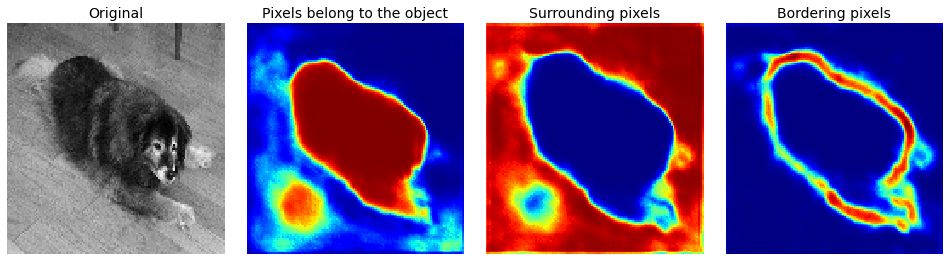

In [24]:
i_sample = 0

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_pred[i_sample, ..., 1], cmap=plt.cm.jet)
AX[3].pcolormesh(y_pred[i_sample, ..., 2], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to the object", fontsize=14);
AX[2].set_title("Surrounding pixels", fontsize=14);
AX[3].set_title("Bordering pixels", fontsize=14);

## Discussion

A segmentation model is proposed based on the architecture of UNET 3+ and is trained using the Oxford-IIIT Pets dataset. Result evaluation indicates that this segmentation model can distinguish pixes of a pet from image backgrounds.

Many technical details of this work, for example, network hyper-parameters and training strategy, can be improved for achieving better performance. 

**Reference**

* Parkhi, O.M., Vedaldi, A., Zisserman, A. and Jawahar, C.V., 2012, June. Cats and dogs. In 2012 IEEE conference on computer vision and pattern recognition (pp. 3498-3505). IEEE.

* Huang, H., Lin, L., Tong, R., Hu, H., Zhang, Q., Iwamoto, Y., Han, X., Chen, Y.W. and Wu, J., 2020, May. UNet 3+: A Full-Scale Connected UNet for Medical Image Segmentation. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 1055-1059). IEEE.